In [1]:
import time
import os
import sys
import pandas as pd
from pathlib import Path

sys.path.append(os.path.join(Path().resolve(), "utils"))

DATA_DIR = Path().resolve() / "data"

from TestUser import TestUser
from get_resource_status import get_resource_status


challenge_id = 1

min_concurrent_instances = 5
max_concurrent_instances = 50
step_concurrent_instances = 5

duration_seconds_per_test = 10
resource_status_polling_interval_seconds = 1

timeout_until_measurement_seconds = 10


df = pd.DataFrame(columns=[
    'concurrent_instances',
    'average_cpu_percent',
    'max_cpu_percent',
    'min_cpu_percent',
    'average_memory_percent',
    'max_memory_percent',
    'min_memory_percent'
])

users = []

for amount in range(min_concurrent_instances, max_concurrent_instances + 1, step_concurrent_instances):
    print(f'Starting test with {amount} concurrent instances...')


    print('Creating users...')

    new_users = []
    for i in range(len(users), amount):
        user = TestUser(
            username=f'testuser_{i+1}',
            password='testpass',
            email=f'test{i+1}@test.com'
        )
        new_users.append(user)

    for user in new_users:
        user.create()

    print('Launching challenges...')

    for user in new_users:
        user.launch_challenge(challenge_id)

    users.extend(new_users)

    print('Waiting for all challenges to be running...')
    time.sleep(timeout_until_measurement_seconds)

    start_time = time.time()

    print('Collecting resource status data...')
    cpu_percents = []
    memory_percents = []
    while True:
        try:
            status = get_resource_status()

            if status is None:
                print('Failed to get resource status, retrying...')
                time.sleep(resource_status_polling_interval_seconds)
                continue
            
            cpu_percents.append(status['cpu'] * 100)
            memory_percent = status['memory']['used'] / status['memory']['total'] * 100
            memory_percents.append(memory_percent)

        except Exception as e:
            print(f'Error getting resource status: {e}')

        while time.time() - start_time < resource_status_polling_interval_seconds:
            pass

        if time.time() - start_time >= duration_seconds_per_test:
            break

    print('Finished collecting resource status data.')

    average_cpu_percent = sum(cpu_percents) / len(cpu_percents)
    max_cpu_percent = max(cpu_percents)
    min_cpu_percent = min(cpu_percents)

    average_memory_percent = sum(memory_percents) / len(memory_percents)
    max_memory_percent = max(memory_percents)
    min_memory_percent = min(memory_percents)

    df = pd.concat([df, pd.DataFrame([{
        'concurrent_instances': amount,
        'average_cpu_percent': average_cpu_percent,
        'max_cpu_percent': max_cpu_percent,
        'min_cpu_percent': min_cpu_percent,
        'average_memory_percent': average_memory_percent,
        'max_memory_percent': max_memory_percent,
        'min_memory_percent': min_memory_percent
    }])], ignore_index=True)

    print(f'Test with {amount} concurrent instances completed.')
    print(f'Average CPU Percent: {average_cpu_percent:.2f}%')
    print(f'Max CPU Percent: {max_cpu_percent:.2f}%')
    print(f'Min CPU Percent: {min_cpu_percent:.2f}%')
    print(f'Average Memory Percent: {average_memory_percent:.2f}%')
    print(f'Max Memory Percent: {max_memory_percent:.2f}%')
    print(f'Min Memory Percent: {min_memory_percent:.2f}%')
    print()

print('Starting cleanup...')
print('Stopping challenges...')
for user in users:
    user.stop_challenge(challenge_id)
    time.sleep(.5)

print('Deleting users...')

for user in users:
    user.delete()
    time.sleep(.5)
print('Cleanup completed.')

df.to_csv(DATA_DIR / 'concurrent_challenge_resource_usage.csv', index=False)


Starting test with 5 concurrent instances...
Creating users...
Launching challenges...
Waiting for all challenges to be running...
Finished collecting resource status data.
Test with 5 concurrent instances completed.
Average CPU Percent: 27.28%
Max CPU Percent: 33.36%
Min CPU Percent: 0.00%
Average Memory Percent: 2.78%
Max Memory Percent: 2.99%
Min Memory Percent: 2.55%

Starting test with 10 concurrent instances...
Creating users...


C:\Users\sagis\AppData\Local\Temp\ipykernel_46120\3848071857.py:104: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{


Launching challenges...
Waiting for all challenges to be running...
Finished collecting resource status data.
Test with 10 concurrent instances completed.
Average CPU Percent: 25.22%
Max CPU Percent: 35.10%
Min CPU Percent: 17.68%
Average Memory Percent: 5.31%
Max Memory Percent: 5.48%
Min Memory Percent: 5.08%

Starting test with 15 concurrent instances...
Creating users...
Launching challenges...
Waiting for all challenges to be running...
Finished collecting resource status data.
Test with 15 concurrent instances completed.
Average CPU Percent: 28.98%
Max CPU Percent: 36.72%
Min CPU Percent: 19.21%
Average Memory Percent: 7.99%
Max Memory Percent: 8.16%
Min Memory Percent: 7.81%

Starting test with 20 concurrent instances...
Creating users...
Launching challenges...
Waiting for all challenges to be running...
Finished collecting resource status data.
Test with 20 concurrent instances completed.
Average CPU Percent: 31.95%
Max CPU Percent: 47.70%
Min CPU Percent: 13.84%
Average Memor

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

DATA_DIR = Path().resolve() / "data"

# Load data
df = pd.read_csv(DATA_DIR / 'concurrent_challenge_resource_usage.csv')

cpu_stats = df.melt(
    id_vars=['concurrent_instances'],
    value_vars=['average_cpu_percent', 'max_cpu_percent', 'min_cpu_percent'],
    var_name='Metric',
    value_name='CPU Percent'
)

cpu_stats.replace(
    {
        'average_cpu_percent': 'Average CPU Percent',
        'max_cpu_percent': 'Max CPU Percent',
        'min_cpu_percent': 'Min CPU Percent'
    },
    inplace=True
)


memory_stats = df.melt(
    id_vars=['concurrent_instances'],
    value_vars=['average_memory_percent', 'max_memory_percent', 'min_memory_percent'],
    var_name='Metric',
    value_name='Memory Percent'
)

memory_stats.replace(
    {
        'average_memory_percent': 'Average Memory Percent',
        'max_memory_percent': 'Max Memory Percent',
        'min_memory_percent': 'Min Memory Percent'
    },
    inplace=True
)

In [3]:
df.head()

,concurrent_instances,average_cpu_percent,max_cpu_percent,min_cpu_percent,average_memory_percent,max_memory_percent,min_memory_percent
0,5,27.279667,33.363636,0.000000,2.778958,2.993974,2.550818
1,10,25.222135,35.103510,17.681729,5.308570,5.475078,5.079538
2,15,28.978504,36.723164,19.212219,7.987087,8.159120,7.813352
3,20,31.948144,47.697368,13.835878,10.781981,10.854478,10.633666
4,25,33.625291,43.343343,25.146199,13.615525,13.721875,13.548998


In [4]:
cpu_stats.head()

,concurrent_instances,Metric,CPU Percent
0,5,Average CPU Percent,27.279667
1,10,Average CPU Percent,25.222135
2,15,Average CPU Percent,28.978504
3,20,Average CPU Percent,31.948144
4,25,Average CPU Percent,33.625291


In [5]:
memory_stats.head()

,concurrent_instances,Metric,Memory Percent
0,5,Average Memory Percent,2.778958
1,10,Average Memory Percent,5.308570
2,15,Average Memory Percent,7.987087
3,20,Average Memory Percent,10.781981
4,25,Average Memory Percent,13.615525


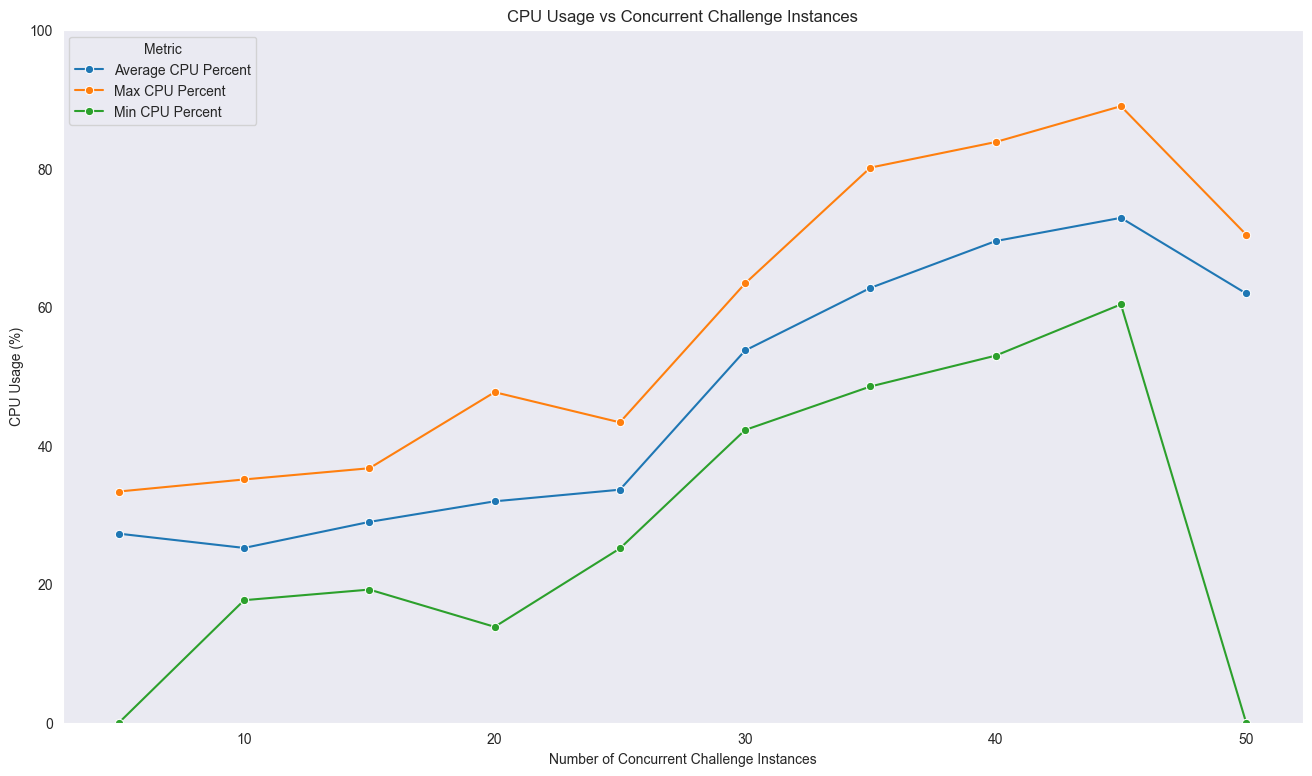

In [6]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=cpu_stats, x='concurrent_instances', y='CPU Percent', hue='Metric', marker='o')
plt.title('CPU Usage vs Concurrent Challenge Instances')
plt.xlabel('Number of Concurrent Challenge Instances')
plt.ylabel('CPU Usage (%)')
plt.ylim(0, 100)
plt.grid()
plt.show()


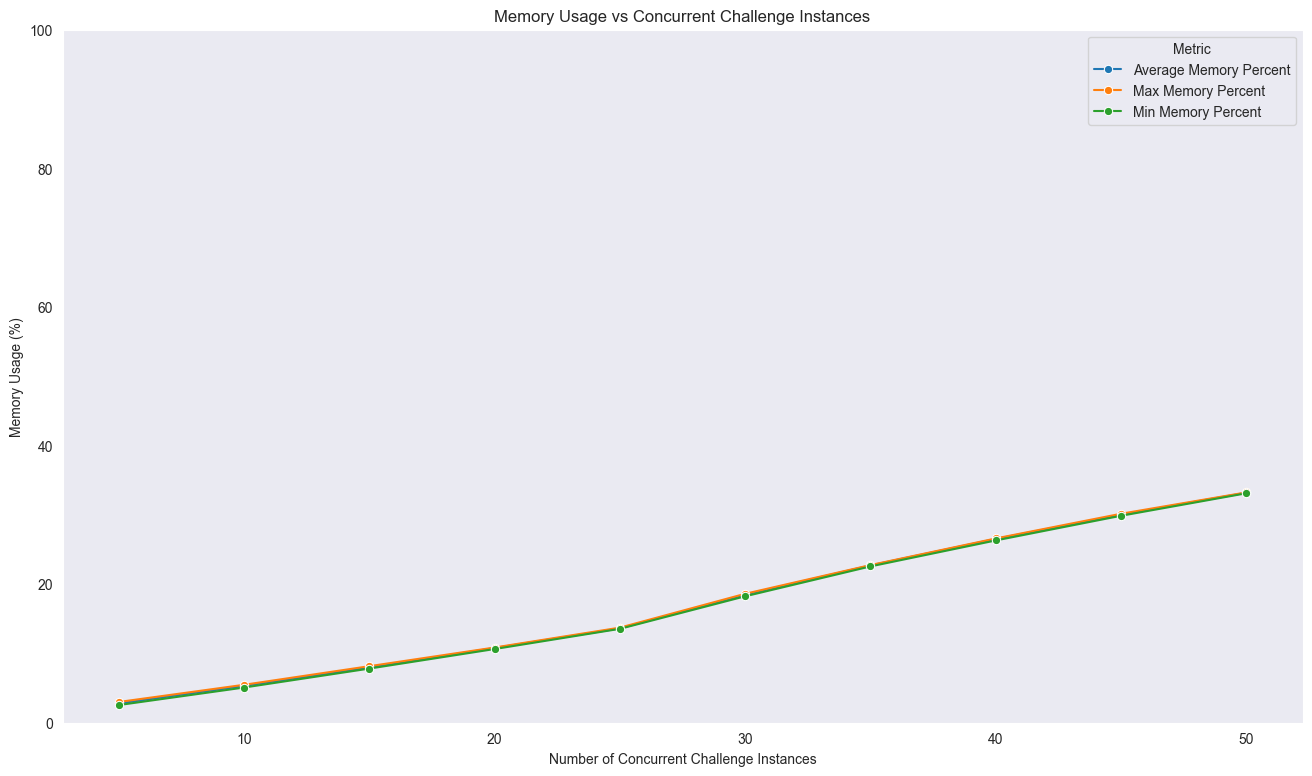

In [7]:
plt.figure(figsize=(16, 9))

sns.lineplot(data=memory_stats, x='concurrent_instances', y='Memory Percent', hue='Metric', marker='o')
plt.title('Memory Usage vs Concurrent Challenge Instances')
plt.xlabel('Number of Concurrent Challenge Instances')
plt.ylabel('Memory Usage (%)')
plt.ylim(0, 100)
plt.grid()
plt.show()